In [1]:
from facetorch import FaceAnalyzer
from omegaconf import OmegaConf
import torchvision
import cv2
from datetime import timedelta
from tqdm import tqdm
import numpy as np

In [2]:
path_config="detector.yml"
cfg = OmegaConf.load(path_config)
analyzer = FaceAnalyzer(cfg.analyzer)

video_path = "/media/kyrollosd/FAA/Cabin/rowL-3.mp4"
video = cv2.VideoCapture(video_path)
fps = video.get(cv2.CAP_PROP_FPS)
nb_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

In [3]:
start =timedelta(minutes=6,seconds=30)
if not video.set(cv2.CAP_PROP_POS_MSEC,1000*start.total_seconds()):
    print('Video does not have timestamp')


In [4]:
if not video.isOpened():
    print("Error opening video file")
    exit()

frame_interval = int(fps)*10  
curr = int(video.get(cv2.CAP_PROP_POS_FRAMES))
while True:
    ret, frame = video.read()
    if not ret:
        break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    response = analyzer.run(
            image=frame,
            batch_size=8,
            include_tensors=True,
            return_img_data=True,
            fix_img_size = False
        )
    curr += frame_interval
    video.set(cv2.CAP_PROP_POS_FRAMES,curr)
    pose = [f.preds['align'].other['pose'] for f in response.faces]
    pil_image = torchvision.transforms.functional.to_pil_image(response.img)
    break

video.release()

In [7]:
from math import cos, sin
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),4)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),4)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),4)

    return img

In [8]:
img =  np.array(pil_image)
for p in pose:
    yaw,pitch,roll = p['angles']
    print(yaw)
    x,y,z = p['translation'].cpu().numpy()
    
    img = draw_axis(img,yaw,pitch,roll,x,y)

-17.561987179502044
4.04226588481062
38.80577434896954
21.82096981722526


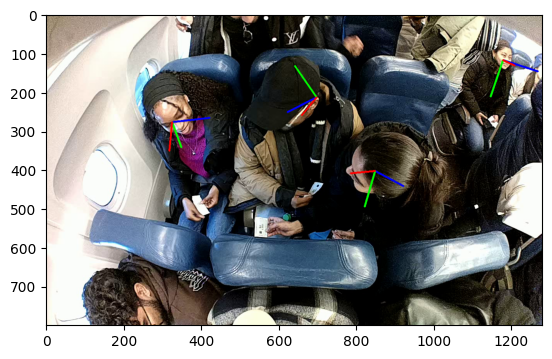

In [9]:
import matplotlib.pyplot as plt 
plt.imshow(img)